In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression


### Import data

In [33]:
originalDataX = pd.read_csv('data/Data_X.csv')
originalDataY = pd.read_csv('data/Data_Y.csv')
originalDataNew = pd.read_csv('data/DataNew_X.csv')

In [34]:
# Merge X and Y

df = pd.merge(originalDataX, originalDataY, on='ID')


### Data Preparation


In [35]:
# Remove unnecessary columns

df = df.drop(['ID'], axis=1)

In [36]:
# Remove duplicated values
df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [49]:
# Label encoding

le = LabelEncoder()
le.fit(['FR', 'DE'])
df['COUNTRY'] = le.transform(df['COUNTRY'])


print(df.head())

KeyError: 'COUNTRY'

In [46]:
# Scale data
sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)




### Data Exploration

In [48]:
# List columns
print(df.columns)

RangeIndex(start=0, stop=35, step=1)


In [40]:
# Describe data
print(df.describe())

                 0             1             2             3             4    
count  1.494000e+03  1.494000e+03  1.494000e+03  1.494000e+03  1.469000e+03  \
mean  -1.379233e-16 -3.091384e-17 -1.093874e-16  1.902390e-17  2.902149e-17   
std    1.000335e+00  1.000335e+00  1.000335e+00  1.000335e+00  1.000341e+00   
min   -1.715791e+00 -1.150428e+00 -4.000386e+00 -1.569977e+00 -2.795524e+00   
25%   -8.685660e-01 -1.150428e+00 -6.905414e-01 -7.584076e-01 -7.523541e-01   
50%   -2.497310e-03  8.692420e-01 -1.045481e-01 -4.072487e-01 -1.936263e-02   
75%    8.519755e-01  8.692420e-01  7.347372e-01  7.299161e-01  8.087210e-01   
max    1.806463e+00  8.692420e-01  2.386278e+00  3.614582e+00  2.866637e+00   

                 5             6             7             8             9    
count  1.469000e+03  1.370000e+03  1.424000e+03  1.370000e+03  1.424000e+03  \
mean  -2.902149e-17 -3.630510e-17 -2.494883e-18  3.630510e-17  2.494883e-18   
std    1.000341e+00  1.000365e+00  1.000351e+00  1.

In [41]:
# Variance
print(df.var())

0     1.000670
1     1.000670
2     1.000670
3     1.000670
4     1.000681
5     1.000681
6     1.000730
7     1.000703
8     1.000730
9     1.000703
10    1.000670
11    1.000670
12    1.000670
13    1.000670
14    1.000670
15    1.000670
16    1.000670
17    1.000670
18    1.000670
19    1.000670
20    1.000670
21    1.000670
22    1.000670
23    1.000670
24    1.000670
25    1.000715
26    1.000715
27    1.000715
28    1.000715
29    1.000715
30    1.000715
31    1.000670
32    1.000670
33    1.000670
34    1.000670
dtype: float64


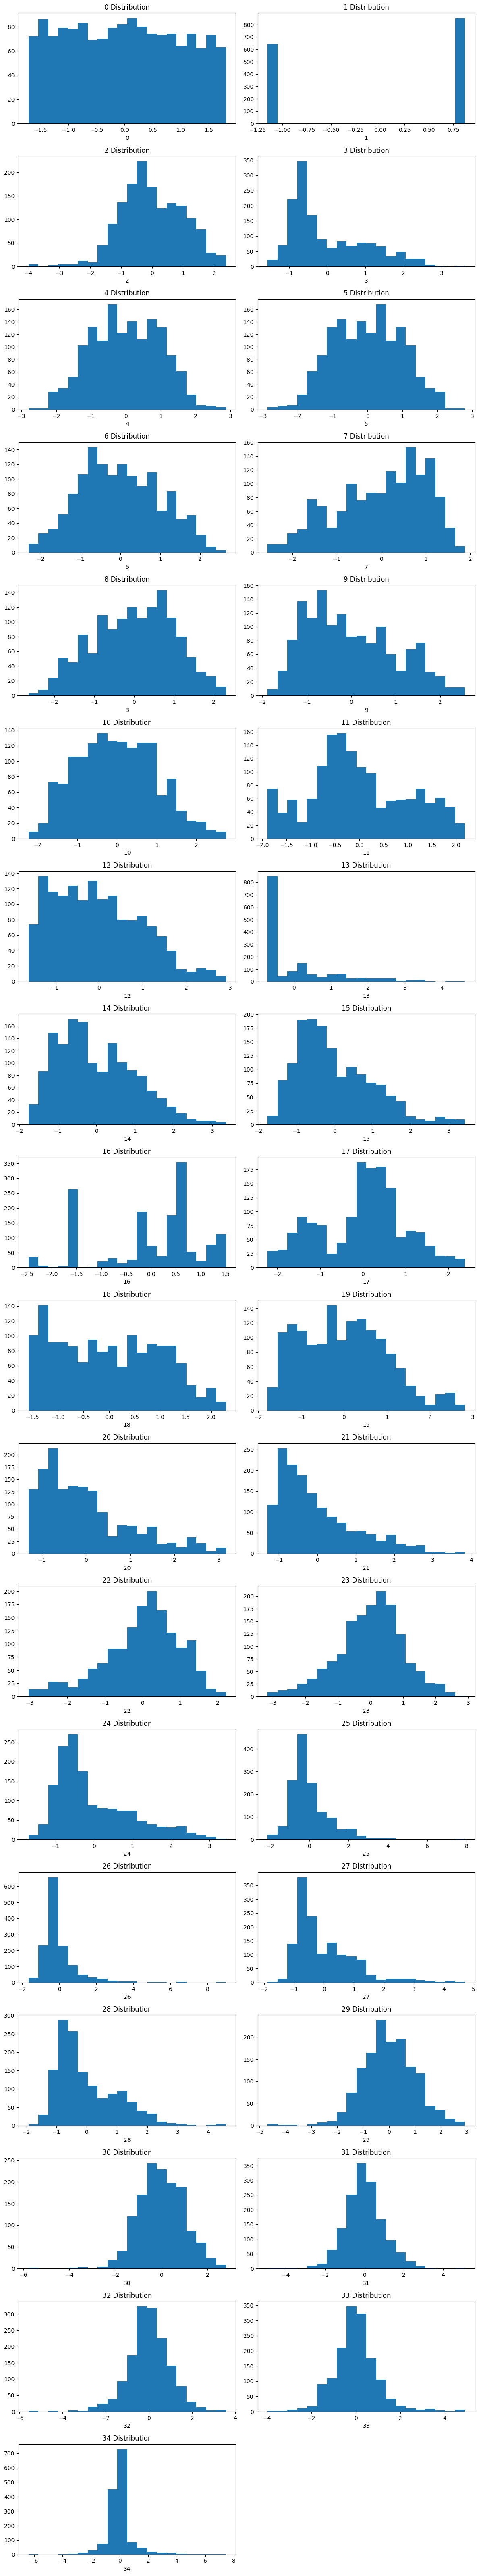

In [42]:
#Plot repartition of the data

plt.figure(figsize=(12,64))

for i, j in enumerate(df.columns):
    plt.subplot(18,2, i+1)
    # Histogram
    plt.hist(df[j], bins=20)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.subplots_adjust(wspace=.2, hspace=.5)
    plt.tight_layout()
plt.show()

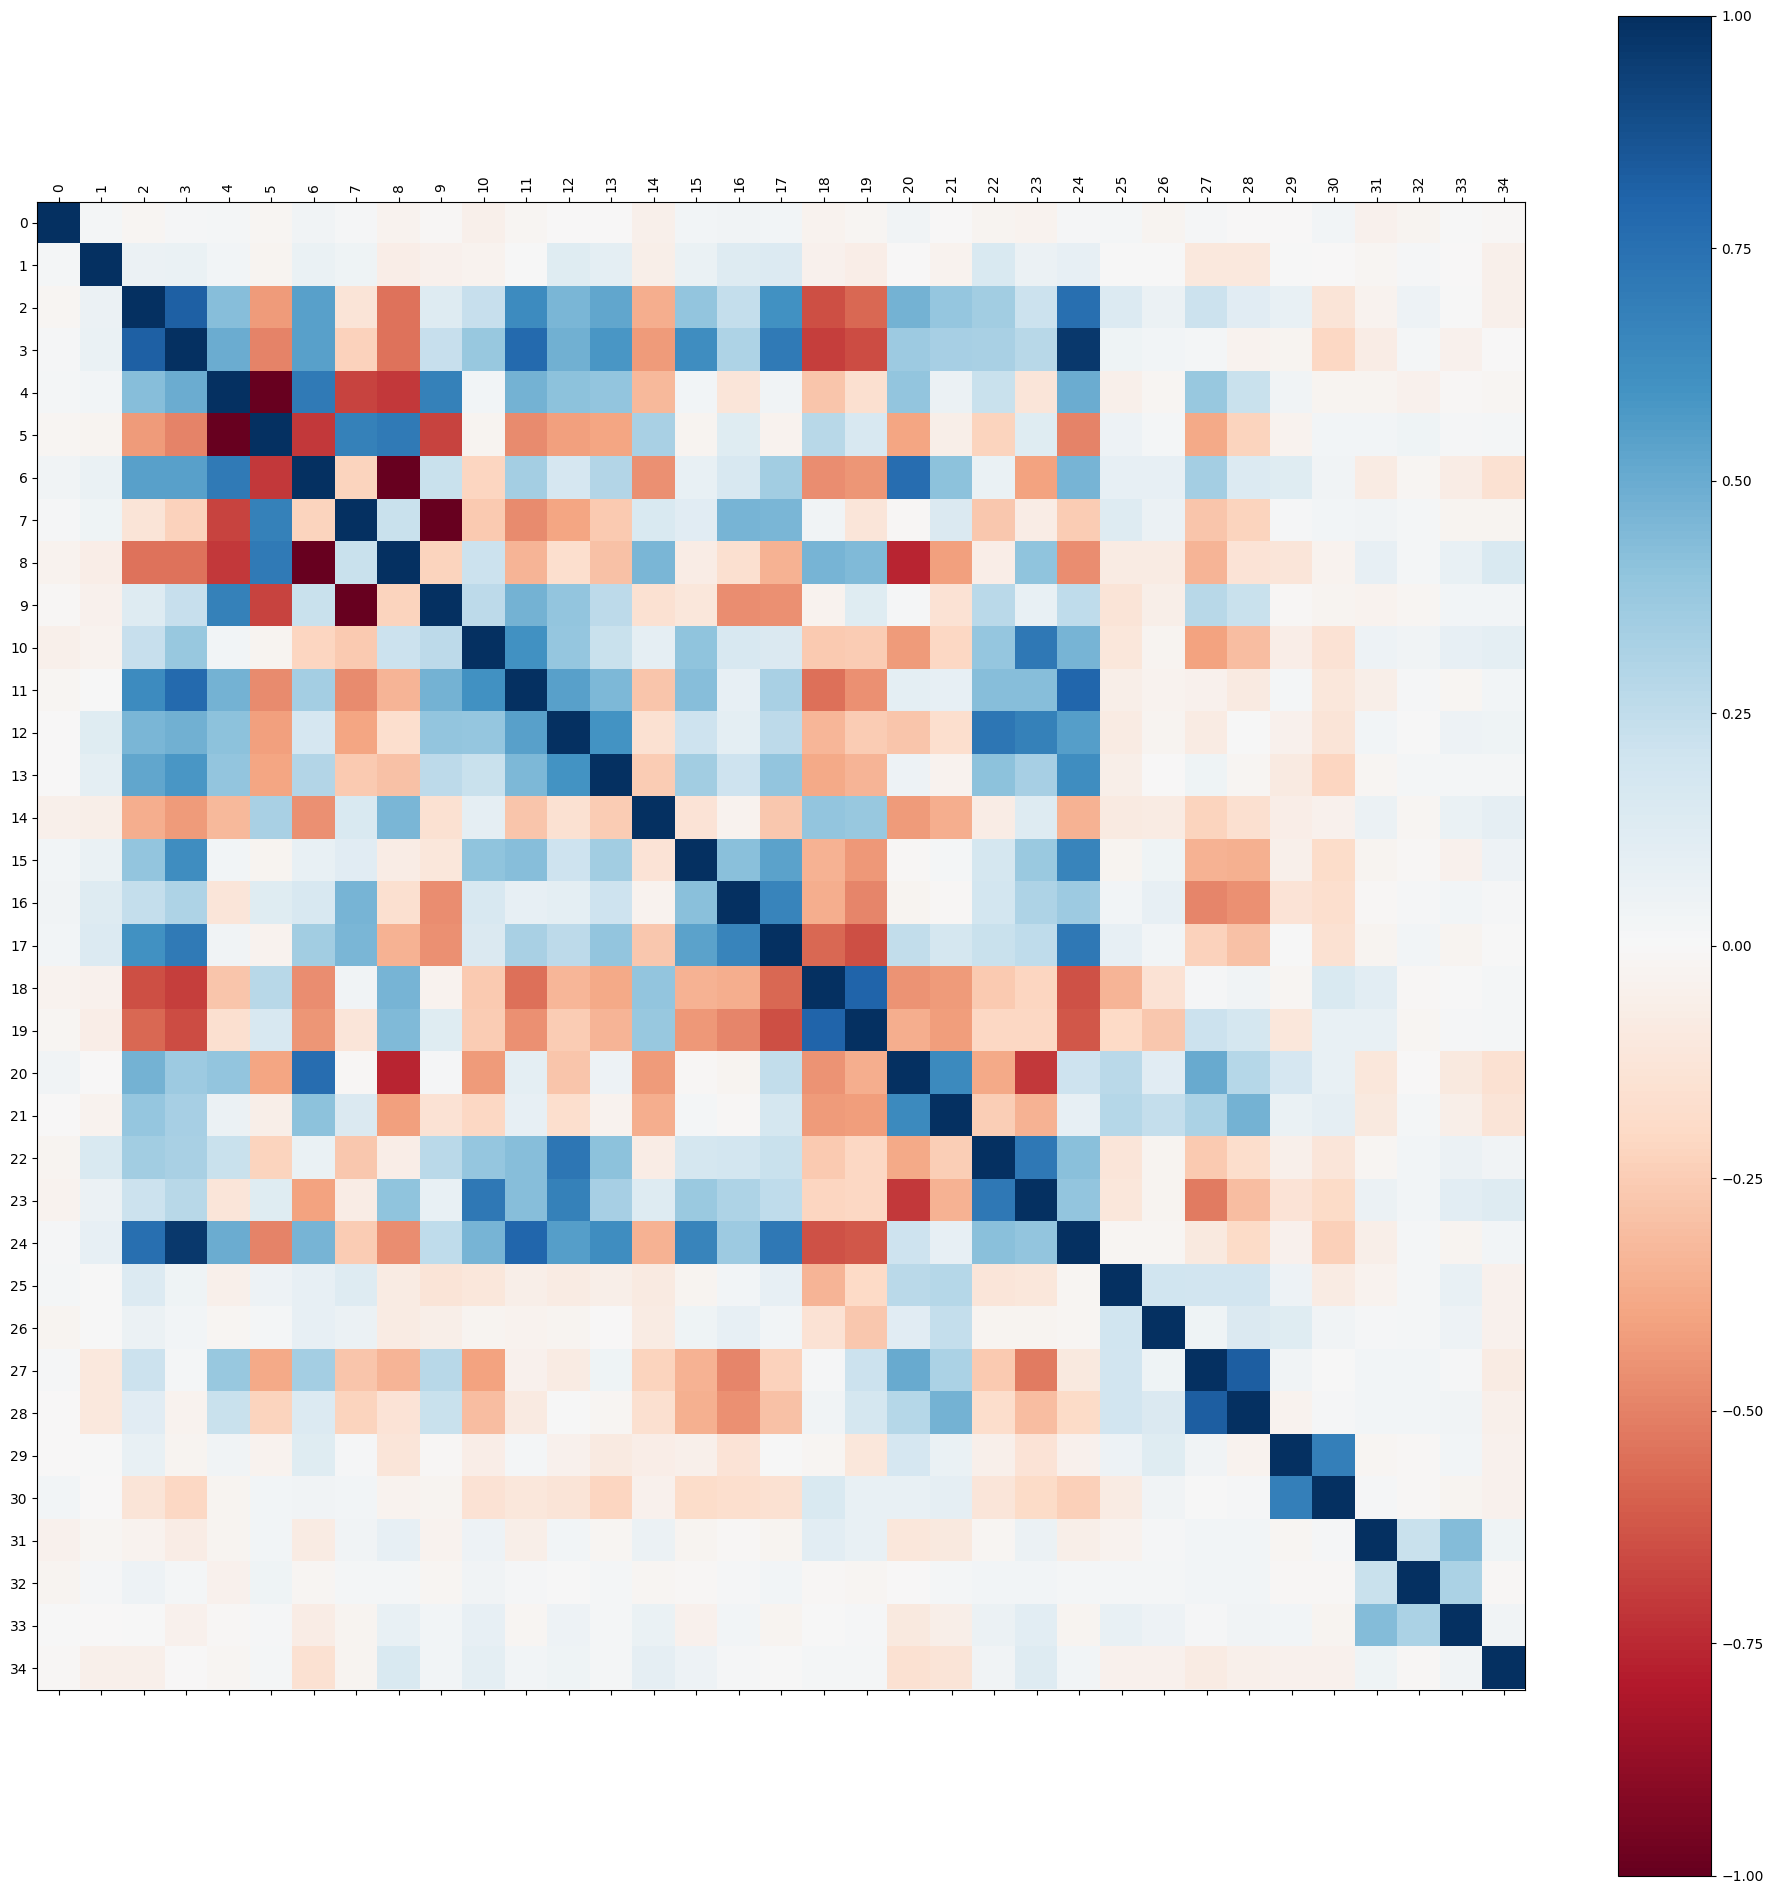

In [43]:
# Plot correlation matrix with heatmap

corr = df.corr()

plt.figure(figsize=(24, 24))
plt.matshow(corr, fignum=1, cmap='RdBu')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [44]:
# Print each column correlation with each other
treashold = 0.75
variable_seen = []

for i in df.columns:
    for j in df.columns:
        if (i, j) not in variable_seen:
            variable_seen += [(j, i)]
            if i != j and df[i].corr(df[j]) > treashold or df[i].corr(df[j]) < -treashold :
                print("{:>20} <---> {:<20} :  {}".format(i, j, df[i].corr(df[j])))


                   2 <---> 3                    :  0.8132017057921074
                   2 <---> 24                   :  0.7541421978532984
                   3 <---> 11                   :  0.7797271465379931
                   3 <---> 24                   :  0.9650862507900644
                   4 <---> 5                    :  -1.0
                   6 <---> 8                    :  -1.0
                   6 <---> 20                   :  0.7633981271837322
                   7 <---> 9                    :  -1.0
                   8 <---> 20                   :  -0.7633981271837322
                  11 <---> 24                   :  0.7959142919276715
                  18 <---> 19                   :  0.8033807850273871
                  27 <---> 28                   :  0.8207241242953595


##### Interpretation of correlations

What we can deduce is that the french and german's consumption is extremely linked, with a correlation of 80%.
We can also see that the french consumption is linked to the gas consumption at 78%, so french electricity depends on gas a lot.
The more the french consumption augments, the more they use the residual load, because there aren't enough renewable energies. We can also see that the residual load is mostly constitued by gas.
Germans export a lot of wind energy.

When french's solar energy is high, the german's solar energy is high too, most likely because the two countries are close and subject to the same weather conditions.

### Data Analysis

In [45]:
# linear regression
X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('Coefficients: \n', reg.coef_)
# Print coefficient for each variable
for i, j in enumerate(X.columns):
    print("{} : {}".format(j, reg.coef_[i]))

print('Intercept: \n', reg.intercept_)
print('Mean squared error: %.2f' % np.mean((y_pred - y_test) ** 2))  
print('Coefficient of determination: %.2f' % reg.score(X_test, y_test))

# Plot outputs
plt.figure(figsize=(12,64))

for i, j in enumerate(X.columns):
    plt.subplot(18,2, i+1)
    plt.scatter(X_test[j], y_test,  color='black')
    plt.plot(X_test[j], y_pred, color='blue', linewidth=1)
    plt.xlabel(j)
    plt.title(j)
    plt.subplots_adjust(wspace=.2, hspace=.5)
    plt.tight_layout()

# plt.scatter(X_test['FR_NET_EXPORT'], y_test,  color='black')
# plt.plot(X_test['FR_NET_EXPORT'], y_pred, color='blue', linewidth=1)
# plt.show()


KeyError: "['TARGET'] not found in axis"